In [ ]:

!pip uninstall tensorflow

Found existing installation: tensorflow 2.10.0
Uninstalling tensorflow-2.10.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.10.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.10.0


In [ ]:
!pip install tensorflow
!pip install tensorflow-io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tensorflow-2.10.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (578.0 MB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio

In [ ]:
POS_TEST_FILE = os.path.join('drive','MyDrive','audio_dataset','chainsaw_split','0.wav')
NEG_TEST_FILE = os.path.join('drive','MyDrive','audio_dataset','background_split','0.wav')

In [ ]:
def load_wav_16k_mono(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [ ]:
wave = load_wav_16k_mono(POS_TEST_FILE)
nwave = load_wav_16k_mono(NEG_TEST_FILE)

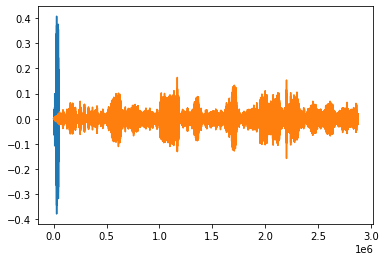

In [ ]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

In [ ]:
POS = os.path.join('drive','MyDrive','audio_dataset','chainsaw_split')
NEG = os.path.join('drive','MyDrive','audio_dataset','background_split')

In [ ]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

In [ ]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [ ]:
lengths = []
for file in os.listdir(os.path.join('drive','MyDrive','audio_dataset','chainsaw_split')):
    tensor_wave = load_wav_16k_mono(os.path.join('drive','MyDrive','audio_dataset','chainsaw_split', file))
    lengths.append(len(tensor_wave))

In [ ]:
print(lengths)
tf.math.reduce_mean(lengths)
print(lengths)
tf.math.reduce_min(lengths)
print(lengths)
tf.math.reduce_max(lengths)
print(lengths)

[48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000, 48000

In [ ]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [ ]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [ ]:
spectrogram, label = preprocess(filepath, label)

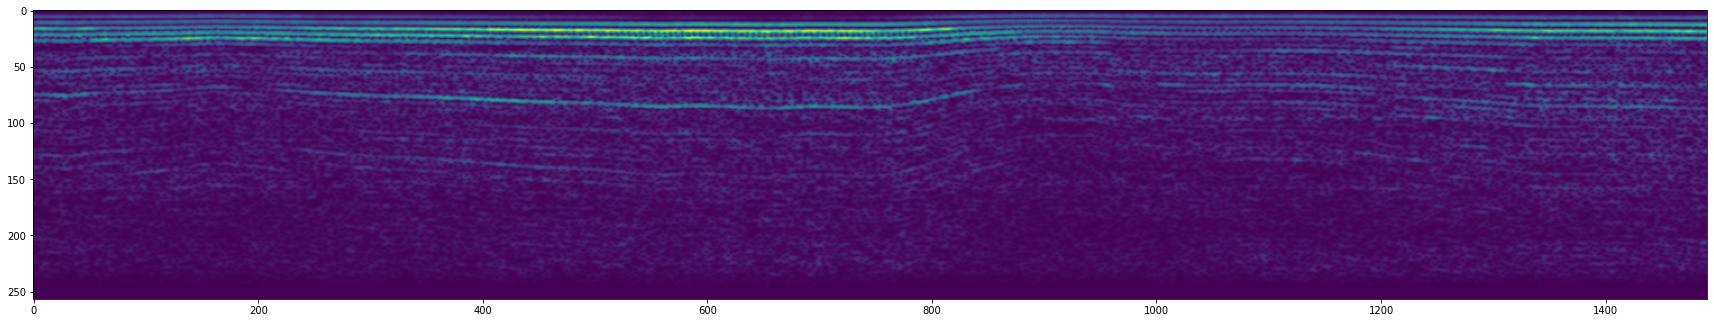

In [ ]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [ ]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [ ]:
train = data.take(36)
test = data.skip(36).take(15)

In [ ]:
samples, labels = train.as_numpy_iterator().next()

In [ ]:
type(samples)

In [ ]:
samples.shape

In [ ]:
import cv2
import numpy as np

In [ ]:
a = np.resize(samples,(16,512,257,1))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(1491, 257, 1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


In [ ]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 32)     320       
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 16)     4624      
                                                                 
 flatten (Flatten)           (None, 6019376)           0         
                                                                 
 dense (Dense)               (None, 16)                96310032  
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 96,314,993
Trainable params: 96,314,993
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist = model.fit(train, epochs=10, validation_data=test)

Epoch 1/10
36/36 [==============================] - 20s 253ms/step - loss: 0.0921 - recall: 0.9693 - precision: 0.9731 - val_loss: 2.3165e-04 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 2/10
36/36 [==============================] - 8s 230ms/step - loss: 0.0348 - recall: 0.9981 - precision: 0.9885 - val_loss: 2.7716e-04 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 3/10
36/36 [==============================] - 8s 231ms/step - loss: 0.0017 - recall: 1.0000 - precision: 1.0000 - val_loss: 2.0535e-04 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 4/10
36/36 [==============================] - 8s 232ms/step - loss: 1.3028e-04 - recall: 1.0000 - precision: 1.0000 - val_loss: 4.5639e-05 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 5/10
36/36 [==============================] - 8s 231ms/step - loss: 5.6057e-05 - recall: 1.0000 - precision: 1.0000 - val_loss: 2.9426e-05 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 6/10
36/36 [==============================] - 8s 234ms/

In [ ]:
model = tf.keras.models.load_model('mymodel.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

385262940

In [ ]:
model.save('mymodel.h5')

In [ ]:
X_test, y_test = test.as_numpy_iterator().next()

In [ ]:
model = tf.keras.models.load_model('mymodel.h5')
model.predict(X_test)

1/1 [==============================] - 0s 198ms/step


array([[1.0000000e+00],
       [9.9999738e-01],
       [9.9999976e-01],
       [9.9992847e-01],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.9999714e-01],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.9993062e-01],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [3.0078748e-24]], dtype=float32)

In [ ]:
print(y_test)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]


In [ ]:
model.set_tensor(input_details[0]['index'],inp)
model.invoke()
output_data = model.get_tensor(output_details[0]['index'])
out = np.squeeze(output_data)

AttributeError: ignored

In [ ]:
input_details

[{'name': 'serving_default_conv2d_input:0',
  'index': 0,
  'shape': array([   1, 1491,  257,    1], dtype=int32),
  'shape_signature': array([  -1, 1491,  257,    1], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [ ]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path='/content/drive/MyDrive/converted_model.tflite')
# interpreter = model
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Set up your input data.
# right = result.rightHand.hand
# input_data = np.array([[res.x, res.y, res.z] for res in right]).flatten()

# Invoke the model on the input data
interpreter.set_tensor(input_details[0]['index'], np.expand_dims(X_test[-1],axis=0))
interpreter.invoke()

# Get the result 
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)



[[3.0093093e-24]]


In [ ]:
!python --version


Python 3.7.15


In [ ]:
!tensorflow --version

/bin/bash: tensorflow: command not found


In [ ]:
print(tf.__version__)

2.10.0


In [ ]:
print(tfio.__version__)

0.27.0
